In [1]:
import os
import sys
import json
from pprint import pprint

src_dir = os.path.join('..', 'src')
sys.path.append(os.path.abspath(src_dir))

import numpy as np
import pandas as pd

from tqdm import tqdm

from data import get_dataset

In [2]:
data = get_dataset('timeseries_v4.1.csv')

../../data/datasets/timeseries_v4.1.csv


In [3]:
data

,post_id,datetime,new_comments,texts,cumsum
0,l0hnrw,2021-01-19 11:00:33,105.0,hi hi today fucking green gunna today fucking ...,105.0
1,l0hnrw,2021-01-19 11:10:33,62.0,die gang gme bb till die gang gme bb till time...,167.0
2,l0hnrw,2021-01-19 11:20:33,68.0,dropouts head listening pm trapt strong watchi...,235.0
3,l0hnrw,2021-01-19 11:30:33,84.0,deleted deleted ride bb ride bb open ashamed r...,319.0
4,l0hnrw,2021-01-19 11:40:33,60.0,insolvent make wsb mutual moment accidentally ...,379.0
...,...,...,...,...,...
2302843,l6yy64,2021-06-05 03:49:16,0.0,,0.0
2302844,l6yy64,2021-06-05 03:59:16,0.0,,0.0
2302845,l6yy64,2021-06-05 04:09:16,0.0,,0.0
2302846,l6yy64,2021-06-05 04:19:16,0.0,,0.0


In [4]:
def reshape_for_lstm(df, x_columns: list, y_column: str, samples_per_post: int = 288, past: int = 6, future: int = 12):
    assert df.shape[0] % samples_per_post == 0, 'Data shape not dividable by samples_per_post number'

    x_list = []
    y_list = []
    for i in tqdm(range(0, df.shape[0], samples_per_post)):
        subset = df.iloc[i:i + samples_per_post, :]
        subset.reset_index(inplace=True)

        x = subset.iloc[:past, :].loc[:, x_columns].to_numpy().reshape((past, len(x_columns)))
        y = subset.iloc[future, subset.columns.get_loc(y_column)]

        x_list.append(x)
        y_list.append(y)

    return np.array(x_list), np.array(y_list)

In [5]:
reshape_for_lstm(data[:2*288], ['new_comments'], 'cumsum')

100%|██████████| 2/2 [00:00<00:00, 663.39it/s]


(array([[[105.],
         [ 62.],
         [ 68.],
         [ 84.],
         [ 60.],
         [ 68.]],
 
        [[  5.],
         [  6.],
         [  3.],
         [  3.],
         [  1.],
         [  1.]]]),
 array([913.,  24.]))

In [6]:
def train_test_split(df, test_size: float = 0.2, random_state: int = 130759):
    ids_df = pd.DataFrame(df.post_id.unique())
    test_ids = ids_df.sample(int(ids_df.shape[0] * test_size), random_state=random_state)

    mask = df.post_id.isin(test_ids.iloc[:, 0])

    return df[~mask], df[mask]

In [7]:
train, test = train_test_split(data)

In [8]:
x, y = reshape_for_lstm(test, ['new_comments'], 'cumsum')

100%|██████████| 1599/1599 [00:01<00:00, 930.25it/s]


In [9]:
pd.DataFrame(y).iloc[:, 0].value_counts()

0.0       323
1.0       147
2.0       121
3.0        93
4.0        81
         ... 
235.0       1
146.0       1
384.0       1
398.0       1
1211.0      1
Name: 0, Length: 169, dtype: int64

In [10]:
a, b = reshape_for_lstm(train, ['new_comments'], 'cumsum')

100%|██████████| 6397/6397 [00:06<00:00, 961.60it/s] 


In [11]:
pd.DataFrame(b).iloc[:, 0].value_counts()

0.0      1207
1.0       574
2.0       538
3.0       433
4.0       351
         ... 
253.0       1
148.0       1
197.0       1
164.0       1
215.0       1
Name: 0, Length: 298, dtype: int64

In [12]:
data[data['cumsum'] > 0.0]

,post_id,datetime,new_comments,texts,cumsum
0,l0hnrw,2021-01-19 11:00:33,105.0,hi hi today fucking green gunna today fucking ...,105.0
1,l0hnrw,2021-01-19 11:10:33,62.0,die gang gme bb till die gang gme bb till time...,167.0
2,l0hnrw,2021-01-19 11:20:33,68.0,dropouts head listening pm trapt strong watchi...,235.0
3,l0hnrw,2021-01-19 11:30:33,84.0,deleted deleted ride bb ride bb open ashamed r...,319.0
4,l0hnrw,2021-01-19 11:40:33,60.0,insolvent make wsb mutual moment accidentally ...,379.0
...,...,...,...,...,...
2302555,l692zd,2021-05-30 16:10:47,0.0,,1.0
2302556,l692zd,2021-05-30 16:20:47,0.0,,1.0
2302557,l692zd,2021-05-30 16:30:47,0.0,,1.0
2302558,l692zd,2021-05-30 16:40:47,0.0,,1.0


In [13]:
def get_cumulative(df):
    result_df = pd.DataFrame()

    for id_ in tqdm(df.post_id.unique()):
        subset = df[df.post_id == id_]
        subset.loc[:, 'cumsum'] = subset.new_comments.cumsum()

        result_df = result_df.append(subset)

    return result_df

In [14]:
# dummy = get_cumulative(data)

In [15]:
# from data import save_dataset

In [16]:
# save_dataset(dummy, 'timeseries_v4.1.csv')

In [55]:
def plot(plot_data, future, y_pred, y_true, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
#     time_steps = list(range(-(plot_data[0].shape[0]), 0))
    time_steps = [-x * 10 for x in range(len(plot_data), 0, -1)]

    plt.title(title)
#     for i, val in enumerate(plot_data):
#         if i:
#             plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
#         else:
#             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.plot(time_steps, plot_data, marker[0], markersize=10, label=labels[0])
    plt.plot([future], [y_pred], marker[2], label=labels[2])
    plt.plot([future], [y_true], marker[1], label=labels[1])
            
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

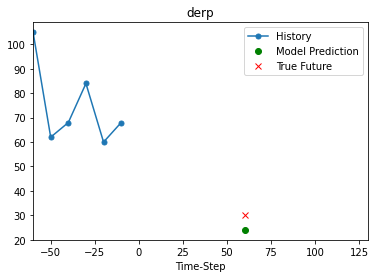

[-60, -50, -40, -30, -20, -10]

In [56]:
ss = [a[0][x][0] for x in range(len(a[0]))]
plot(ss, 60, 24, 30, 'derp')
[-x * 10 for x in range(len(ss), 0, -1)]

In [21]:
from matplotlib import pyplot as plt

In [35]:
[a[0][x][0] for x in range(len(a[0]))]

[105.0, 62.0, 68.0, 84.0, 60.0, 68.0]

In [29]:
a[0]

array([[105.],
       [ 62.],
       [ 68.],
       [ 84.],
       [ 60.],
       [ 68.]])

In [57]:
b[0]

913.0